# Transcriptomics Tutorial


## Introduction
> Cell phenotype is controlled by gene expression regulation, a phenomenon discovered by Barbara McClintock in early 1950s, later described by  Francois Jacob and Jacques Monod in bacteria. Since the discovery of the entire human DNA sequence, scientists have now the knowledge and technology to quantify precisely gene expression at whole genome scale. A particularly interesting layer of regulation occurs at the transcriptome level. The transcriptome is the set of all RNA molecules in the cell. Cellular phenotype is particularly impacted by the pool of messenger RNAs (mRNAs), which results from the transcription of specific genes and serves as template for protein translation. Through the use of transcriptomics techniques, we can determine the abundance of each mRNA in a cell, therefore determining the levels of gene expression. Quantifying gene expression levels in our cells helps us understand important biological phenomena like cell differentiation and mechanisms of human disease.

> There are two main transcriptomics technologies use to measure gene expression: (1) [Microarrays](https://en.wikipedia.org/wiki/DNA_microarray) is an older technique used to measure relative abundance of gene expression. We will not cover microarrays here, but this [video](https://www.youtube.com/watch?v=6ZzFihESjp0) does a great job explaining how microarrays works, and (2) RNA sequencing (RNA-seq). In this tutorial, we will focus only focus on RNA-seq data analysis.


##  RNA-seq

> [RNA-seq](https://en.wikipedia.org/wiki/RNA-Seq) is a technology to quantify gene expression by determining the abundance of specific RNA sequences. There are three main steps to RNA-seq: library preparation, sequencing, and data analysis. 

> Let's start with the steps happening in the lab. First, we isolate mRNA. Then, using the enzyme reverse transcriptase, mRNA is converted into its complementary DNA strand, cDNA. The cDNA is then cut up into small fragments, usually a few hundred base-pairs long. [Next generation sequencing technologies](https://en.wikipedia.org/wiki/Illumina_dye_sequencing) use fluorescence-tagged nucleotides that bind to short cDNA sequences to recapitulate the sequence of the sample by sequencing, in a massively parallel manner. Each sequenced read (call *reads*) are stored into a file of [FASTQ format](https://en.wikipedia.org/wiki/FASTQ_format).

> Later, as part of the data analysis pipeline, theses files containing the sequence of the reads are then cleaned using quality control pipelines, then mapped their sequence to a specific genome / transcriptome / set of features.

## File Structure

> Organization is a very important skill for any bioinformatics project that is oftentimes overlooked. There is no standard file hierarchy to use, but we will use a file structure that is fairly common among many research scientists:

<html>
<div style="width: 50%;margin: 0 auto; background-color: rgb(242, 242, 242);">
    <code><i>project_name</i>/
    data/
        BAM/
        cleanFASTQ/
        cufflinks/
        FASTQ/
        kallisto/
        microbesOnline/
        seqData/
        transcriptomeIndex/</code>
</div>
</html>

> Also, we will store all downloaded software in a  folder called *software* in the home directory, ~/software, and add binaries of downloaded software to the [PATH](https://en.wikipedia.org/wiki/PATH_(variable)). Instructions for adding to your PATH on Mac can be found [here](https://coolestguidesontheplanet.com/add-shell-path-osx/).

## Setup

> Below, we will assign the path to the working directory as a global variable that will be used throughout the rest of the notebook.

In [0]:
###IMPORTANT: if you ever restart this notebook, you MUST rerun this code cell
import os

#feel free to change this location, because we will be working in this folder for the entire tutorial
os.environ['WORKDIR'] = './data' 

In [0]:
#create the directory if doesn't exist already
!mkdir -p $WORKDIR


# RNA-Seq Data Analysis
> In this tutorial, we will use a subset of samples from a published work, where they investigated how microbes adapt to new environments ([PMID 28854640](https://www.ncbi.nlm.nih.gov/pubmed/28854640)). Following standard practices in science, the authors made all data required to reproduce their findings, including the reads for several transcriptome samples, publically available (SRA Project [SRP106486](https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP106486)).

First, we need to download the raw data, which in this case is a file of 500 MB. For a connection speed of around 6 MB/s, the file will download in about 2 minutes, but download time will vary depending on your internet connection. Afterwards, move the file into the $WORKDIR/seqData/ folder.

In [0]:
!wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR551/SRR5511057/SRR5511057.sra

--2019-02-05 17:30:41--  ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR551/SRR5511057/SRR5511057.sra
           => ‘SRR5511057.sra’
Resolving ftp-trace.ncbi.nih.gov (ftp-trace.ncbi.nih.gov)... 130.14.250.7
Connecting to ftp-trace.ncbi.nih.gov (ftp-trace.ncbi.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /sra/sra-instant/reads/ByRun/sra/SRR/SRR551/SRR5511057 ... done.
==> SIZE SRR5511057.sra ... 455056642
==> PASV ... done.    ==> RETR SRR5511057.sra ... done.
Length: 455056642 (434M) (unauthoritative)

SRR5511057.sra      100%[===================>] 433.98M  6.28MB/s    in 83s     

2019-02-05 17:32:05 (5.24 MB/s) - ‘SRR5511057.sra’ saved [455056642]



***
If the above command returned `wget: command not found`, means you don't have the command `wget` in your machine. Then, try installing Homebrew, run `brew install wget` in terminal, and then try the above command again.

## Preparing the file
You may notice that we downloaded a `.sra` file. This file format contains the raw sequencing data and alignment information in a compressed form. We will convert this into [FASTQ](https://en.wikipedia.org/wiki/FASTQ_format) format, which is the standard file format for storing RNA-seq raw data. FASTQ is a text-based format for storing the biological sequence and its corresponding quality scores. Each read is encoded with 4 lines in strict order:

* Line 1: beings with '@' character with an identifier for the sequence and an optional description.
* Line 2: raw nucleotide sequence.
* Line 3: begins with '+' character with the same sequence identifier and additional optional description.
* Line 4: quality of each nucleotide.

To help us convert this file into FASTQ, you will need to download [SRA Toolkit](https://www.ncbi.nlm.nih.gov/books/NBK158900/).
Although this toolkit contains many helpful tools to help us work with sequencing data, there is only one command we need to learn for now:

`fastq-dump --split-files -O <outputDir> <sraFile>`

This command converts the .sra file into FASTQ format. The --split-files tag specifies whether our data was obtained using single-end sequencing or paired-end sequencing. Single-end sequencing means that each hybridized fragment is read once, while paired-end sequencing means that each hybridized fragment is read twice (once from each end). Paired-end sequencing results in twice as many reads compared to single-end sequencing, so is therefore more costly, but improves accuracy and the quality of the sequencing.

In [0]:
!fastq-dump --split-files -O $WORKDIR/FASTQ $WORKDIR/seqData/SRR5511057.sra

Read 7370822 spots for ./data/seqData/SRR5511057.sra
Written 7370822 spots for ./data/seqData/SRR5511057.sra


Our data was sequenced using paired-end sequencing, so we used the `--split-files` flag. You should see two new files in your $WORKDIR/FASTQ folder: `SRR5511057_1.fastq` and `SRR5511057_2.fastq`. If you inspect the SRR5511057_1.fastq file with the `head` command, we can see what our reads look like in FASTQ format. Here is the first read, corresponding to the first 4 lines of the file (notice that line 2 and line 4 are exactly the same length! Why does that make sense?<sub>(1)</sub>):

<div style="border:solid 1px; padding:5px">
@SRR5511057.1 1 length=76 <br>
GTCCACACAAGCCAAATGGTGAAATGCAGTTCTGGGTGTGCCTAGGTATAAGGATTTGTCCTTCTTGCTGACAGCT <br>
+SRR5511057.1 1 length=76 <br>
AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE/EEEEEEEEEEEEEAEEEEE
</div>

## Converting Raw Data into Usable Data

There are three overall steps in RNA-seq transcriptome qualification:
1. **Cleaning reads.** Reads typically have a length of 75-250 bp (base-pairs). Due to molecular noise, not all positions of the read have the same likelihood of that event being true. For this reason, we have to clean and trim the data.
2. **Mapping reads.** We need to associate reads to our reference features, e.g., transcripts. For this task, we need the FASTQ files and a reference annotation: (1) a set of files that define the genome, typically FASTA files and (2) a file defining where transcripts are located in the genome, typically a GFF3 file. The output of the mapping algorithms is a BAM file, which is a compressed binary file that contains the aligned reads to the reference.
3. **Quantifying reads.** Next, we need to associate an expression value to each feature, i.e., quantify the level of expression of our transcripts from the reads alignment.

There are 3 major units for quantifying reads: 
- FPKM: is useful for visualization across genes and samples because it accounts for the variability of transcript length and experimental sequencing depth. This is useful, since longer transcripts will produce more transcript fragments by chance, and in turn will have more reads associated with it since the longer the transcript.
- TPM: is similar to FPKM, but it normalizes each gene expression to a constant derived from the sum of expression across all genes. This is helpful for comparison among samples where effective transcript lenght changes. Here's a very helpful [blog post and video](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/) understanding the difference between TPM and FPKM.
- _counts_: is the raw number of reads that match to the transcript. It is useful for statistical purposes. 


***
In the following section, we will walk through 3 different pipelines that we can use to clean, map, and quantify the reads.

### Pipeline A: Trimmomatic/STAR/cufflinks

**1a.** [Trimmomatic](http://www.usadellab.org/cms/?page=trimmomatic) is a Java software to trim and remove low quality reads. It also removes adapter sequences from library preparation. After downloading the software from its site, extract the zip file and move it into the ~/software folder. Next, execute the following command:

In [0]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/SRR5511057_1.fastq $WORKDIR/FASTQ/SRR5511057_2.fastq \
    $WORKDIR/cleanFASTQ/SRR5511057.forward_paired.fastq $WORKDIR/cleanFASTQ/SRR5511057.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/SRR5511057.reverse_paired.fastq $WORKDIR/cleanFASTQ/SRR5511057.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticPE: Started with arguments:
 -phred33 ./data/sequence_data/SRR5511057_1.fastq ./data/sequence_data/SRR5511057_2.fastq ./data/sequence_data/SRR5511057.forward_paired.fastq ./data/sequence_data/SRR5511057.forward_unpaired.fastq ./data/sequence_data/SRR5511057.reverse_paired.fastq ./data/sequence_data/SRR5511057.reverse_unpaired.fastq LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Multiple cores found: Using 4 threads
Input Read Pairs: 7370822 Both Surviving: 6915652 (93.82%) Forward Only Surviving: 369084 (5.01%) Reverse Only Surviving: 56673 (0.77%) Dropped: 29413 (0.40%)
TrimmomaticPE: Completed successfully


Let's look over the arguments used in this command. 
- `PE` stands for paired end, which is the type of sequencing our sample data came from. 
- `-phred33` [Phred](https://en.wikipedia.org/wiki/Phred_quality_score) + 33 Quality Score.
- `$WORKDIR/FASTQ/SRR5511057_1.fastq` `$WORKDIR/FASTQ/SRR5511057_2.fastq` is the relative location for our input data.
- `$WORKDIR/cleanFASTQ/SRR5511057.forward_paired.fastq` `$WORKDIR/cleanFASTQ/SRR5511057.forward_unpaired.fastq` is the relative location for our output forward paired and unpaired data, respectively.
- `$WORKDIR/cleanFASTQ/SRR5511057.reverse_paired.fastq` `$WORKDIR/cleanFASTQ/SRR5511057.reverse_unpaired.fastq` is the relative location for our output reverse paired and unpaired data, respectively.
- `LEADING:3` removes leading bases with a low quality (below quality 3).
- `TRAILING:3` removes trailing bases with a low quality (below quality 3).
- `SLIDINGWINDOW:4:15` scans the read with a 4-base sliding window, cutting when the average quality per base drops below 15.
- `MINLEN:36` drops reads below the 36 bases long.

DNA is double-stranded, but one strand is designated as the "forward strand" while the other strand is designated as the "reverse strand". Another common term for this is plus/minus strands. Since paired-end sequencing reads match both directions, the reads that are complementary to the forward strand are called "reverse reads", while the reads that are complementary with the reverse strand are called "forward reads". 

In paired-end sequencing, reads come in pairs (each fragment yields two reads, one from each end), so if one of the reads is trimmed off by the criteria we set when running Trimmomatic, Trimmomatic will automatically remove the corresponding read and label both reads as "unpaired".
***

**1b.** [Star](https://github.com/alexdobin/STAR) (Spliced Transcripts Alignment to a Reference) is a C++ program to align reads to a reference genome. For performance efficiency, its first step is building an index of our reference genome (this step only needs to be done once!).

First, we will need to download STAR software and untar the file. Afterwards, remember to place STAR in the ~/software folder and add it to your PATH.

In [0]:
!wget https://github.com/alexdobin/STAR/archive/2.7.0d.tar.gz
!tar -xzf 2.7.0d.tar.gz

--2019-02-19 10:27:34--  https://github.com/alexdobin/STAR/archive/2.7.0d.tar.gz
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/alexdobin/STAR/tar.gz/2.7.0d [following]
--2019-02-19 10:27:35--  https://codeload.github.com/alexdobin/STAR/tar.gz/2.7.0d
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121, 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘2.7.0d.tar.gz’

2.7.0d.tar.gz           [        <=>         ]   7.69M  4.94MB/s    in 1.6s    

2019-02-19 10:27:36 (4.94 MB/s) - ‘2.7.0d.tar.gz’ saved [8062298]



**1c.** The first step to mapping our reads is to generate an index. Since we are interested in the expression of transcripts, we will download the reference transcriptome sequence from [MicrobesOnline](http://www.microbesonline.org/), an online database of microbial genomic information. Our data was generated in a sample from yeast, or scientifically known as *Saccharomyces ceravisiae*, so we need the FASTA transcriptome for yeast from [here](http://www.microbesonline.org/cgi-bin/genomeInfo.cgi?tId=4932). Unzip the file, and move the resulting file to the $WORKDIR/microbesOnline folder. Then, we will need to make a new folder to store the transcriptome indices.

In [0]:
!mkdir $WORKDIR/transcriptomeIndex

To build the index, we will run the following command.

In [0]:
!STAR --runThreadN 8 --runMode genomeGenerate \
    --genomeDir $WORKDIR/transcriptomeIndex --genomeFastaFiles $WORKDIR/microbesOnline/4932.transcriptomes.fasta

Feb 19 15:13:26 ..... started STAR run
Feb 19 15:13:26 ... starting to generate Genome files
Feb 19 15:13:35 ... starting to sort Suffix Array. This may take a long time...
Feb 19 15:13:40 ... sorting Suffix Array chunks and saving them to disk...
Feb 19 15:13:46 ... loading chunks from disk, packing SA...
Feb 19 15:13:48 ... finished generating suffix array
Feb 19 15:13:48 ... generating Suffix Array index
Feb 19 15:13:55 ... completed Suffix Array index
Feb 19 15:13:55 ... writing Genome to disk ...
Feb 19 15:13:57 ... writing Suffix Array to disk ...
Feb 19 15:13:57 ... writing SAindex to disk
Feb 19 15:13:59 ..... finished successfully


Each -- defines a new parameter, which are options we specify to STAR
- `--runThreadN 8` specifies the number of threads on your computer (hint: run `sysctl -n hw.ncpu` to find out!).
- `--runMode genomeGenerate` means that we are building the genome index.
- `--genomeDir $WORKDIR/transcriptomeIndex` saves the output the the folder we just created.
- `--genomeFastaFiles` are the reference genome sequences (in this case we are using the transcriptome) we are building our index from.

**1d.** Now, we map our reads to the transcriptome!

In [0]:
!STAR --runThreadN 4 --genomeDir $WORKDIR/transcriptomeIndex \
    --readFilesIn $WORKDIR/cleanFASTQ/SRR5511057.forward_paired.fastq $WORKDIR/cleanFASTQ/SRR5511057.reverse_paired.fastq \
     --outSAMtype BAM SortedByCoordinate --outFileNamePrefix $WORKDIR/BAM/


Apr 11 22:45:32 ..... started STAR run
Apr 11 22:45:32 ..... loading genome
Apr 11 22:45:38 ..... started mapping
Apr 11 22:46:48 ..... finished mapping
Apr 11 22:46:48 ..... started sorting BAM
Apr 11 22:46:56 ..... finished successfully


If you ran into this error: 

`
BAMoutput.cpp:27:BAMoutput: exiting because of *OUTPUT FILE* error: could not create output file ./data/BAM_STARtmp//BAMsort/4/48`

SOLUTION: check that the path exists and you have write permission for this file. Also check `ulimit -n` and increase it to allow more open files. Also, it may be worth lowering the number of threads or running `ulimit -n 10000` in the terminal.
***

Let's look at the options used in this command:
- `--runThreadN 4` specifies the number of threads you want to use (run `sysctl -n hw.ncpu` to find the number of threads on your computer!).
- `--genomeDir $WORKDIR/transcriptomeIndex` directory where genome index was generated.
- `--readFilesIn` input sequence data to be mapped.
- `--outSAMtype BAM SortedByCoordinate` outputs a BAM file with sorted aligned reads.
- `--outFileNamePrefix` prefix to add to the output file.

Our aligned reads are stored in a BAM format, which is a compressed binary version of [SAM](https://en.wikipedia.org/wiki/SAM_(file_format)), a text-based format for storing aligned reads.

**1e.** We will now use [cufflinks](http://cole-trapnell-lab.github.io/cufflinks/) to quantify the reads per feature. Download the latest version [here](http://cole-trapnell-lab.github.io/cufflinks/install/), and add the directory to your Path. 

In [0]:
!cufflinks $WORKDIR/BAM/Aligned.sortedByCoord.out.bam --library-type fr-firststrand

[22:47:40] Inspecting reads and determining fragment length distribution.
> Processed 6316 loci.                         [*************************] 100%
> Map Properties:
>	Normalized Map Mass: 6039610.00
>	Raw Map Mass: 6039610.00
>	Fragment Length Distribution: Empirical (learned)
>	              Estimated Mean: 157.12
>	           Estimated Std Dev: 62.28
[22:48:28] Assembling transcripts and estimating abundances.
> Processed 6316 loci.                         [*************************] 100%


- `$WORKDIR/BAM/Aligned.sortedByCoord.out.bam` is the file of RNA-seq read alignments in BAM or SAM format
- `--library-type fr-firststrand` specifies the library used to prepare our data, we used Illumina's stranded Tru-Seq which is fr-firststrand

Cufflinks should generate 4 files: genes.fpkm_tracking, isoforms.fpkm_tracking, skipped.gtf, and transcripts.gtf. Move these files into your $WORKDIR/cufflinks folder. 

We are interested in the genes.fpkm_tracking file. In our example, we used the FASTA transcriptome to build the STAR index, so the genes.fpkm_tracking file quantifies the expression of every transcript. However, if we were to use the FASTA genome and a GFF3 annotation file to build the STAR index, genes.fpkm_tracking would quantify gene expression while isoforms.fpkm_tracking would quantify the expression for all possible exons.

You can open genes.fpkm_tracking using any text editor. You should have a table that looks like the following:

|tracking_id	| class_code | nearest_ref_id | gene_id | gene_short_name | tss_id | locus | length | coverage | FPKM | FPKM_conf_lo | FPKM_conf_hi | FPKM_status |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| CUFF.1 | - | - | CUFF.1 | - | - | VIMSS6580636:30-1540 | - | - | 3.54675 | 2.207 | 4.8865 | OK |
| CUFF.2 | - | - | CUFF.2 | - | - | VIMSS6580642:3238-3969 | - | - | 19.8471 | 14.9253 | 24.769 | OK |
| ... |

In this tutorial, we only care about a few of the columns:
1. `gene_id` is the Cufflinks gene id
2. `locus` is where the reads was aligned to on the transcriptome, for example: VIMSS6580636:30-1540 means on VIMSS6580636 transcript from the 30th to the 1540th base pair
3. `FPKM` is level of transcript expression in FPKM
4. `FPKM_conf_lo` is the lower bound of the 95% confidence interval for FPKM
5. `FPKM_conf_hi` is the upper bound of the 95% confidence interval for FPKM
6. `FPKM_status` is fairly self-explanatory

By looking at the FPKM value, we can gain a general understanding of the level of expression of each transcript:
- 0-10 is considered low
- 10-100 is considered medium
- 100-1000 is considered high
- 1000+ is considered very high

**Question:** If we used pipeline A to measure gene expression in humans and built the STAR index using the entire human genome and an annotation file, would the genes.fpkm_tracking file or isoforms.fpkm_tracking file have more entries?<sub>(2)</sub>

### Pipeline B: Trimmomatic/killisto
If you have walked through pipeline A, you can skip Trimmomatic because you have already cleaned the reads.
If you still need to clean your data, see instructions for [Trimmomatic](http://www.usadellab.org/cms/?page=trimmomatic) in pipeline A, then return here.

[Kallisto](https://pachterlab.github.io/kallisto/) is a program that appeared in [2015](https://liorpachter.wordpress.com/2015/05/10/near-optimal-rna-seq-quantification-with-kallisto/) developed in Lior Patcher's group. It is based on _pseudo-alignment_ using [k-mers](https://en.wikipedia.org/wiki/K-mer) instead of reads. It is fast, accurate, and robust. And simple to use. All you need it to create is an index of your transcriptome (or any target reference sequence) and you will be ready to apply it on your FASTQ files. This [video](https://www.youtube.com/watch?v=94wphB3GKBM) has a great explanation of how kallisto differs from other mapping tools.

**2a.** The first step is to create a kallisto index, and we can use the same transcriptome FASTA file from pipeline A.

In [0]:
!kallisto index -i $WORKDIR/kallisto/transcripts.idx $WORKDIR/microbesOnline/4932.transcriptomes.fasta


[build] loading fasta file ./data/microbesOnline/4932.transcriptomes.fasta
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 11350 contigs and contains 8201152 k-mers 



**2b.** Kallisto combines the mapping and quantifying steps into one, so unlike pipeline A which first uses STAR to map the reads to a reference genome sequence and then uses cufflinks to quantify the aligned reads, we can run just one command to get a file representing levels of gene expression.

In [0]:
!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/output \
    $WORKDIR/cleanFASTQ/SRR5511057.forward_paired.fastq $WORKDIR/cleanFASTQ/SRR5511057.reverse_paired.fastq


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 6,333
[index] number of k-mers: 8,201,152
[index] number of equivalence classes: 7,745
[quant] running in paired-end mode
[quant] will process pair 1: ./data/cleanFASTQ/SRR5511057.forward_paired.fastq
                             ./data/cleanFASTQ/SRR5511057.reverse_paired.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 6,915,652 reads, 6,505,430 reads pseudoaligned
[quant] estimated average fragment length: 159.718
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 838 rounds



Once the above command has finished, you should see a new folder called `output`. If you look inside, there should be a file called `abundance.tsv` with five columns:
 1. The first column is `target_id`, which is the identifier of the transcript from the FASTA transcriptome we downloaded. 
 2. The second column is `length`, which is the length of the transcript in base pairs. 
 3. The third column is `eff_length`, which stands for effective length. This is the length of the original transcript that matches with reads. 
 4. The fourth column is `est_counts`, which stands for estimated counts. This is almost the same as _counts_, but accounts for the amount of bias in the experiment. 
 5. This fifth column is `tpm`, which is the metric for the level of gene expression.
 
For more information about these expression units, visit [this blog post](https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/).


**Question:** What would you expect to be the most expressed transcript in yeast to be?<sub>(3)</sub>

## Extension 1: Evaluating differentially expressed transcripts 

From this one sample, we can see that some transcripts are expressed more or less than other transcripts, but this data does not give any insight about the effect of changes in transcript abundance and cellular behavior. This is why we need to compare the transcript expression of different samples. For example, imagine we would like to address the following question: which transcripts are responsible for making this a cancerous cell? We would look at the transcript expression between a normal cell and a cancerous cell, and analyze transcripts that are differentially expressed between the two samples. In this extension, we will begin looking at differentially expressed transcripts by visualizing the levels of transcription between different samples.

We will continue to use samples from the adaptive prediction paper ([PMID 28854640](https://www.ncbi.nlm.nih.gov/pubmed/28854640)) to analyze the effects of caffeine on yeast at the transcriptome level. 

Before we download the data from the other samples, let us clean our working directories. For the following folders `$WORKDIR/BAM/`, `$WORKDIR/cleanFASTQ/`, `$WORKDIR/cufflinks/`, `$WORKDIR/FASTQ/`, and `$WORKDIR/kallisto/`, create new folders in each folder specifying the experiment (1a, 1c, 2a, 2c, 3a, 3c). In the pipeline tutorials, we were working with data from 1a, so move any existing files into your new 1a folder. However, in the kallisto folder, leave the transcripts.idx file under /data/kallisto because we can reuse the kallisto index and it should be shared between the samples.

For example, your `$WORKDIR/kallisto/` folder should look something like this:
<html>
<div style="width: 50%;margin: 0 auto; background-color: rgb(242, 242, 242);">
    <code><i>kallisto</i>/
    transcripts.idx
    1a/
        abundance.h5
        abundance.tsv
        run_info.json
    1c/
    2a/
    2c/
    3a/
    3c/</code>
</div>
</html>

We will now download the sequencing data from replicate 1 after caffeine, replicate 2 before and after caffeine, and replicate 3 before and after caffeine. Research scientists use replicates to check that outcomes are not due to chance. This is different from a trial, because a **trial** refers to a certain action performed many times repeatedly using the exact same object, while a **replicate** would perform a certain action on many of the same object. 

An example of a trial is flipping the same coin three times, while replicates would be flipping three different coins.


| Replicate # | Before Caffeine (a) | After Caffeine (c) |
| --- | --- | --- |
| 1 | [SRX2785036](https://www.ncbi.nlm.nih.gov/sra/SRX2785036[accn]) | [SRX2785039](https://www.ncbi.nlm.nih.gov/sra/SRX2785039[accn]) |
| 2 | [SRX2785037](https://www.ncbi.nlm.nih.gov/sra/SRX2785037[accn]) | [SRX2785040](https://www.ncbi.nlm.nih.gov/sra/SRX2785040[accn]) |
| 3 | [SRX2785038](https://www.ncbi.nlm.nih.gov/sra/SRX2785038[accn]) | [SRX2785041](https://www.ncbi.nlm.nih.gov/sra/SRX2785041[accn]) |

SRA toolkit provides a very easy to use executable called `prefetch`, which we can call to help us download the sequencing data files. All we have to do is provide the SRA accession, a unique identifier provided by the [NCBI](https://www.ncbi.nlm.nih.gov/) for each sample.

In [0]:
!prefetch SRX2785037
!prefetch SRX2785038
!prefetch SRX2785039
!prefetch SRX2785040
!prefetch SRX2785041


2019-02-21T21:15:09 prefetch.2.9.4: 1) Downloading 'SRX2785037'...
2019-02-21T21:15:09 prefetch.2.9.4:  Downloading via https...
2019-02-21T21:17:21 prefetch.2.9.4:  https download succeed
2019-02-21T21:17:21 prefetch.2.9.4: 1) 'SRX2785037' was downloaded successfully
2019-02-21T21:17:21 prefetch.2.9.4: 'SRX2785037' has 0 unresolved dependencies

2019-02-21T21:18:37 prefetch.2.9.4: 1) Downloading 'SRX2785038'...
2019-02-21T21:18:37 prefetch.2.9.4:  Downloading via https...
2019-02-21T21:19:41 prefetch.2.9.4:  https download succeed
2019-02-21T21:19:41 prefetch.2.9.4: 1) 'SRX2785038' was downloaded successfully
2019-02-21T21:19:41 prefetch.2.9.4: 'SRX2785038' has 0 unresolved dependencies

2019-02-21T21:20:57 prefetch.2.9.4: 1) Downloading 'SRX2785039'...
2019-02-21T21:20:57 prefetch.2.9.4:  Downloading via https...
2019-02-21T21:22:36 prefetch.2.9.4:  https download succeed
2019-02-21T21:22:36 prefetch.2.9.4: 1) 'SRX2785039' was downloaded successfully
2019-02-21T21:22:36 prefetch.2.9

These files usually download automatically to a new location, the `~/ncbi/public/sra/` folder, so lets move all the files to our /data/seqData folder.

In [0]:
!mv -v  ~/ncbi/public/sra/* $WORKDIR/seqData

/Users/andrewliu/ncbi/public/sra/SRR5511058.sra -> ./data/seqData/SRR5511058.sra
/Users/andrewliu/ncbi/public/sra/SRR5511059.sra -> ./data/seqData/SRR5511059.sra
/Users/andrewliu/ncbi/public/sra/SRR5511060.sra -> ./data/seqData/SRR5511060.sra
/Users/andrewliu/ncbi/public/sra/SRR5511061.sra -> ./data/seqData/SRR5511061.sra
/Users/andrewliu/ncbi/public/sra/SRR5511062.sra -> ./data/seqData/SRR5511062.sra


Using the same procedure as above, let's generate metrics to measure the level of gene expression in each experiment. Feel free to reference above if you need help, but **remember to change file names and locations**.

1. convert to FASTQ
2. clean the reads
3. map the reads to the reference transcriptome sequence (we already generated the transcriptomeIndex, so no need to do it again!)
4. quantify the aligned reads

If you get stuck, here is the list of commands to run:

In [0]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/2a $WORKDIR/seqDATA/SRR5511058.sra

Read 6811851 spots for ./data/seqDATA/SRR5511058.sra
Written 6811851 spots for ./data/seqDATA/SRR5511058.sra


In [0]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/3a $WORKDIR/seqDATA/SRR5511059.sra

Read 2577860 spots for ./data/seqDATA/SRR5511059.sra
Written 2577860 spots for ./data/seqDATA/SRR5511059.sra


In [0]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/1c $WORKDIR/seqDATA/SRR5511060.sra

Read 5187380 spots for ./data/seqDATA/SRR5511060.sra
Written 5187380 spots for ./data/seqDATA/SRR5511060.sra


In [0]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/2c $WORKDIR/seqDATA/SRR5511061.sra

Read 6148895 spots for ./data/seqDATA/SRR5511061.sra
Written 6148895 spots for ./data/seqDATA/SRR5511061.sra


In [0]:
!fastq-dump --split-files -O $WORKDIR/FASTQ/3c $WORKDIR/seqDATA/SRR5511062.sra

Read 4211946 spots for ./data/seqDATA/SRR5511062.sra
Written 4211946 spots for ./data/seqDATA/SRR5511062.sra


In [0]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/2a/SRR5511058_1.fastq $WORKDIR/FASTQ/2a/SRR5511058_2.fastq \
    $WORKDIR/cleanFASTQ/2a/SRR5511058.forward_paired.fastq $WORKDIR/cleanFASTQ/2a/SRR5511058.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/2a/SRR5511058.reverse_paired.fastq $WORKDIR/cleanFASTQ/2a/SRR5511058.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticPE: Started with arguments:
 -phred33 ./data/FASTQ/2a/SRR5511058_1.fastq ./data/FASTQ/2a/SRR5511058_2.fastq ./data/cleanFASTQ/2a/SRR5511058.forward_paired.fastq ./data/cleanFASTQ/2a/SRR5511058.forward_unpaired.fastq ./data/cleanFASTQ/2a/SRR5511058.reverse_paired.fastq ./data/cleanFASTQ/2a/SRR5511058.reverse_unpaired.fastq LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Multiple cores found: Using 4 threads
Input Read Pairs: 6811851 Both Surviving: 6381302 (93.68%) Forward Only Surviving: 341875 (5.02%) Reverse Only Surviving: 58767 (0.86%) Dropped: 29907 (0.44%)
TrimmomaticPE: Completed successfully


In [0]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/3a/SRR5511059_1.fastq $WORKDIR/FASTQ/3a/SRR5511059_2.fastq \
    $WORKDIR/cleanFASTQ/3a/SRR5511059.forward_paired.fastq $WORKDIR/cleanFASTQ/3a/SRR5511059.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/3a/SRR5511059.reverse_paired.fastq $WORKDIR/cleanFASTQ/3a/SRR5511059.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticPE: Started with arguments:
 -phred33 ./data/FASTQ/3a/SRR5511059_1.fastq ./data/FASTQ/3a/SRR5511059_2.fastq ./data/cleanFASTQ/3a/SRR5511059.forward_paired.fastq ./data/cleanFASTQ/3a/SRR5511059.forward_unpaired.fastq ./data/cleanFASTQ/3a/SRR5511059.reverse_paired.fastq ./data/cleanFASTQ/3a/SRR5511059.reverse_unpaired.fastq LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Multiple cores found: Using 4 threads
Input Read Pairs: 2577860 Both Surviving: 2454399 (95.21%) Forward Only Surviving: 99434 (3.86%) Reverse Only Surviving: 16473 (0.64%) Dropped: 7554 (0.29%)
TrimmomaticPE: Completed successfully


In [0]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/1c/SRR5511060_1.fastq $WORKDIR/FASTQ/1c/SRR5511060_2.fastq \
    $WORKDIR/cleanFASTQ/1c/SRR5511060.forward_paired.fastq $WORKDIR/cleanFASTQ/1c/SRR5511060.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/1c/SRR5511060.reverse_paired.fastq $WORKDIR/cleanFASTQ/1c/SRR5511060.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticPE: Started with arguments:
 -phred33 ./data/FASTQ/1c/SRR5511060_1.fastq ./data/FASTQ/1c/SRR5511060_2.fastq ./data/cleanFASTQ/1c/SRR5511060.forward_paired.fastq ./data/cleanFASTQ/1c/SRR5511060.forward_unpaired.fastq ./data/cleanFASTQ/1c/SRR5511060.reverse_paired.fastq ./data/cleanFASTQ/1c/SRR5511060.reverse_unpaired.fastq LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Multiple cores found: Using 4 threads
Input Read Pairs: 5187380 Both Surviving: 4894727 (94.36%) Forward Only Surviving: 224109 (4.32%) Reverse Only Surviving: 44706 (0.86%) Dropped: 23838 (0.46%)
TrimmomaticPE: Completed successfully


In [0]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/2c/SRR5511061_1.fastq $WORKDIR/FASTQ/2c/SRR5511061_2.fastq \
    $WORKDIR/cleanFASTQ/2c/SRR5511061.forward_paired.fastq $WORKDIR/cleanFASTQ/2c/SRR5511061.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/2c/SRR5511061.reverse_paired.fastq $WORKDIR/cleanFASTQ/2c/SRR5511061.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticPE: Started with arguments:
 -phred33 ./data/FASTQ/2c/SRR5511061_1.fastq ./data/FASTQ/2c/SRR5511061_2.fastq ./data/cleanFASTQ/2c/SRR5511061.forward_paired.fastq ./data/cleanFASTQ/2c/SRR5511061.forward_unpaired.fastq ./data/cleanFASTQ/2c/SRR5511061.reverse_paired.fastq ./data/cleanFASTQ/2c/SRR5511061.reverse_unpaired.fastq LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Multiple cores found: Using 4 threads
Input Read Pairs: 6148895 Both Surviving: 5871459 (95.49%) Forward Only Surviving: 218792 (3.56%) Reverse Only Surviving: 40469 (0.66%) Dropped: 18175 (0.30%)
TrimmomaticPE: Completed successfully


In [0]:
!java -jar ~/software/Trimmomatic-0.38/trimmomatic-0.38.jar PE -phred33 \
    $WORKDIR/FASTQ/3c/SRR5511062_1.fastq $WORKDIR/FASTQ/3c/SRR5511062_2.fastq \
    $WORKDIR/cleanFASTQ/3c/SRR5511062.forward_paired.fastq $WORKDIR/cleanFASTQ/3c/SRR5511062.forward_unpaired.fastq \
    $WORKDIR/cleanFASTQ/3c/SRR5511062.reverse_paired.fastq $WORKDIR/cleanFASTQ/3c/SRR5511062.reverse_unpaired.fastq \
    LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticPE: Started with arguments:
 -phred33 ./data/FASTQ/3c/SRR5511062_1.fastq ./data/FASTQ/3c/SRR5511062_2.fastq ./data/cleanFASTQ/3c/SRR5511062.forward_paired.fastq ./data/cleanFASTQ/3c/SRR5511062.forward_unpaired.fastq ./data/cleanFASTQ/3c/SRR5511062.reverse_paired.fastq ./data/cleanFASTQ/3c/SRR5511062.reverse_unpaired.fastq LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Multiple cores found: Using 4 threads
Input Read Pairs: 4211946 Both Surviving: 3988920 (94.70%) Forward Only Surviving: 181396 (4.31%) Reverse Only Surviving: 28039 (0.67%) Dropped: 13591 (0.32%)
TrimmomaticPE: Completed successfully


In [0]:
!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/2a \
    $WORKDIR/cleanFASTQ/2a/SRR5511058.forward_paired.fastq $WORKDIR/cleanFASTQ/2a/SRR5511058.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/3a \
    $WORKDIR/cleanFASTQ/3a/SRR5511059.forward_paired.fastq $WORKDIR/cleanFASTQ/3a/SRR5511059.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/1c \
    $WORKDIR/cleanFASTQ/1c/SRR5511060.forward_paired.fastq $WORKDIR/cleanFASTQ/1c/SRR5511060.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/2c \
    $WORKDIR/cleanFASTQ/2c/SRR5511061.forward_paired.fastq $WORKDIR/cleanFASTQ/2c/SRR5511061.reverse_paired.fastq

!kallisto quant -i $WORKDIR/kallisto/transcripts.idx -o $WORKDIR/kallisto/3c \
    $WORKDIR/cleanFASTQ/3c/SRR5511062.forward_paired.fastq $WORKDIR/cleanFASTQ/3c/SRR5511062.reverse_paired.fastq


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 6,333
[index] number of k-mers: 8,201,152
[index] number of equivalence classes: 7,745
[quant] running in paired-end mode
[quant] will process pair 1: ./data/cleanFASTQ/2a/SRR5511058.forward_paired.fastq
                             ./data/cleanFASTQ/2a/SRR5511058.reverse_paired.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 6,381,302 reads, 6,107,084 reads pseudoaligned
[quant] estimated average fragment length: 158.378
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 995 rounds


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 6,333
[index] number of k-mers: 8,201,152
[index] number of equivalence classes: 7,745
[quant] running in paired-end mode
[quant] will process pair 1: ./data/cleanFASTQ/3a/SRR5511059.forw

We now have the gene expression in 6 different samples in terms of TPM. A common first step is to validate our data through visualization. We can imagine each sample as a single data point on our graph, where we have n-dimensions for the number of transcripts in yeast. We can expect the "before-caffeine samples" to form one cluster and the "after-caffeine experiments" to form another cluster. However, how do we transform our high-dimensional transcript expression data into 2-dimensional data?

We will explore two popular algorithms for dimensionality reduction: [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)(t-distributed stochastic neighbor embedding) and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)(principal component analysis). 

We will use Python and use several different libraries. Downloading python libraries is very easy using the [pip](https://pip.pypa.io/en/stable/quickstart/) command.

In [0]:
#import dependencies
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
import math
from plotnine import *
import numpy as np
import os

In [0]:
#import data
a1 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/1a/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
a2 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/2a/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
a3 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/3a/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
c1 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/1c/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
c2 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/2c/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])
c3 = pd.read_csv(os.environ['WORKDIR'] + '/kallisto/3c/abundance.tsv', sep='\t', header=0, usecols=['target_id', 'tpm'])

#parse each sample's data
a1.rename(columns = {'tpm':'a1'}, inplace = True)
a2.rename(columns = {'tpm':'a2'}, inplace = True)
a3.rename(columns = {'tpm':'a3'}, inplace = True)
c1.rename(columns = {'tpm':'c1'}, inplace = True)
c2.rename(columns = {'tpm':'c2'}, inplace = True)
c3.rename(columns = {'tpm':'c3'}, inplace = True)
a2 = a2.drop('target_id', axis=1)
a3 = a3.drop('target_id', axis=1)
c1 = c1.drop('target_id', axis=1)
c2 = c2.drop('target_id', axis=1)
c3 = c3.drop('target_id', axis=1)

#combine samples into one table, where each row represents a sample and columns represent transcript
dataframe = pd.concat([a1,a2,a3,c1,c2,c3], axis=1)
dataframe = dataframe.T
dataframe.columns = dataframe.iloc[0]
dataframe = dataframe.drop('target_id')

#clear memory, don't need references anymore
del a1,a2,a3,c1,c2,c3

#clean data by removing possible noise
#filter out columns where any value is less than 10 (lowly expressed)
min_threshold = 10
for column in dataframe:
    for value in dataframe[column]:
        if value < min_threshold:
            dataframe.drop(column, axis=1, inplace=True)
            break

#log base 10 all values in dataframe
dataframe.applymap(lambda x: math.log(x, 10))

target_id,VIMSS6580644,VIMSS6580645,VIMSS6580646,VIMSS6580647,VIMSS6580648,VIMSS6580649,VIMSS6580651,VIMSS6580653,VIMSS6580656,VIMSS6580657,...,VIMSS6586892,VIMSS6586893,VIMSS6586898,VIMSS6580614,VIMSS6580621,VIMSS6580622,VIMSS6580627,VIMSS6580628,VIMSS6580629,VIMSS6580612
a1,2.001253,2.314166,1.591324,1.138631,1.495095,1.540466,1.596420,1.880289,1.723808,2.099069,...,1.387208,1.639635,1.821620,2.330458,1.653391,1.996965,1.362009,1.409023,1.801380,1.902422
a2,1.871936,2.351112,1.458062,1.090011,1.459961,1.393377,1.563595,1.805389,1.777433,2.074169,...,1.261981,1.582633,1.857878,2.350058,1.817173,1.938477,1.001145,1.465667,1.930689,1.939737
a3,1.955481,2.315626,1.437268,1.211801,1.492533,1.504729,1.595578,1.846698,1.660973,2.140822,...,1.275938,1.631825,1.801223,2.336622,1.524715,2.082688,1.119444,1.549779,1.980582,1.883486
c1,1.767758,1.876159,1.507000,1.136264,1.357550,1.263331,1.548698,1.813714,1.963342,2.113850,...,1.284956,1.490526,1.831983,2.325329,1.676088,1.928189,1.233260,1.569479,1.906061,1.853782
c2,1.921927,2.002891,1.441230,1.141130,1.332368,1.349048,1.579315,1.799521,1.921784,2.192283,...,1.253885,1.496107,1.850982,2.337631,1.754243,1.941409,1.286061,1.776610,1.915668,1.832984
c3,1.895282,1.935375,1.514434,1.191018,1.364104,1.251660,1.655679,1.814967,1.772066,2.164014,...,1.322463,1.495933,1.912814,2.340575,1.693179,1.943146,1.423976,1.710578,1.997486,1.607802


In [0]:
# perform PCA calculations
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataframe.values)

print ('Explained variation per principal component {}'.format(pca.explained_variance_ratio_))

# perform t-SNE calculations
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=5000, learning_rate = 10)
tsne_results = tsne.fit_transform(dataframe.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

dataframe['PC1'] = pca_result[:,0]
dataframe['PC2'] = pca_result[:,1] 

dataframe['tSNE1'] = tsne_results[:,0]
dataframe['tSNE2'] = tsne_results[:,1]

# add label column to table to identify each sample
dataframe['label'] = pd.Series(['before', 'before', 'before', 'after', 'after', 'after'], index = dataframe.index)

Explained variation per principal component [0.60461493 0.20639627]
[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 7615.190083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.728119
[t-SNE] KL divergence after 1050 iterations: 0.009043
t-SNE done! Time elapsed: 0.17603206634521484 seconds


PCA is a deterministic algorithm that looks for most variant variables across samples. It does this by trying to find a best-fit linear line to the data, which is called the first principal component. The first principal component always accounts for the most variation in the data. Subsequent principal components are the best fitting lines perpendicular to previous principal components. The final points are simply the position of the respective point after being projected onto the principal components. This [video](https://www.youtube.com/watch?v=FgakZw6K1QQ) by StatQuest is very helpful in understanding the step-by-steps of PCA and gaining intuition about how it works. From our example, we can see that 81.1% of the variation in transcript expression in our samples are accounted for by the first and second principal components.

t-SNE is a non-deterministic algorithm for dimensionality reduction. Each point is initiated in a position in the wanted lower-dimension. At each step, t-SNE will measure the distances of each point with each other point, and compare these with the similarity values from the original data. The ultimate goal is to make the similarity values between points on the lower dimension to match with the values from the original dimension. This [video](https://www.youtube.com/watch?v=NEaUSP4YerM) by StatQuest helps explain t-SNE. Keep in mind that t-SNE is non-deterministic, meaning that each run will behave differently and result in different results.

Note: to re-run t-SNE calculations, you have to first reload the data in the previous code cell before running code cell with t-SNE calculations

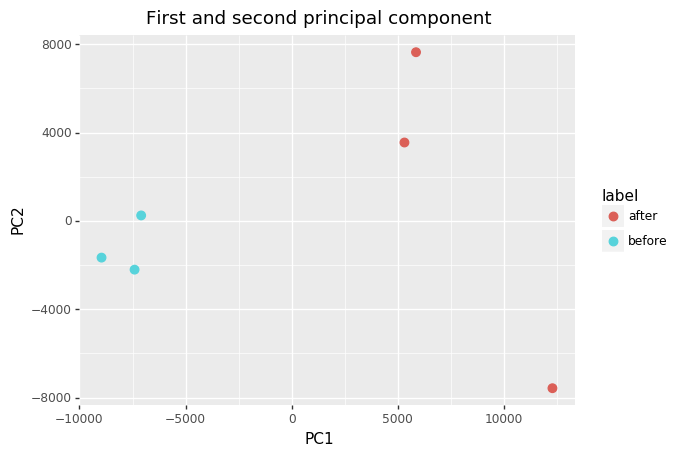

<ggplot: (286316082)>

In [0]:
#graph PCA 
chart = ggplot(dataframe, aes(x='PC1', y='PC2', color='label') ) \
        + geom_point(size=3,alpha=1) \
        + ggtitle("First and second principal component")
chart

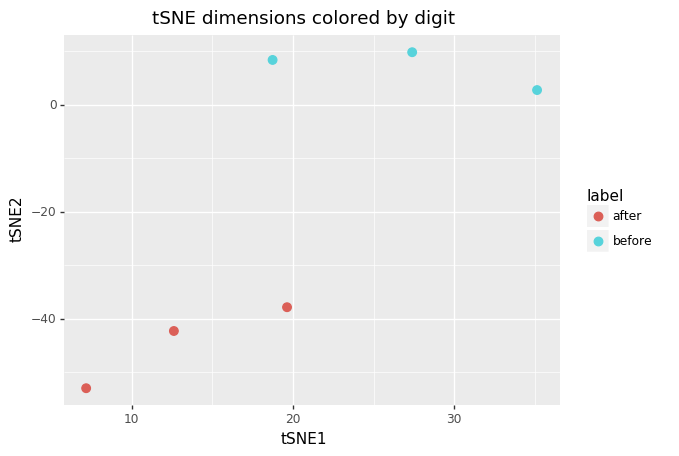

<ggplot: (285572335)>

In [0]:
# graph t-SNE!
chart = ggplot(dataframe, aes(x='tSNE1', y='tSNE2', color='label') ) \
        + geom_point(size=3,alpha=1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In both our PCA and our t-SNE graph, we can see a clear distinction between the before-caffeine cluster and the after-caffeine cluster! This indicates that caffeine is changing transcriptome state as the yeast is reacting to the caffeine in its environment on the transcriptome level.

Although PCA and t-SNE is often only helpful to indicate that transcripts are being differentially expressed, it is still a crucial first step in data analysis. After this, scientists will often use [heatmaps](https://en.wikipedia.org/wiki/Heat_map), [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling), [statistical tests] (https://pachterlab.github.io/sleuth_walkthroughs/trapnell/analysis.html), or other techniques to continue exploring the secrets hidden within the data. We invite you to continue learning about different crucial methods used by researches and to continue investigating how yeast uses gene regulation to respond to chemical changes in its environment.

# Answers
1. Each letter in the fourth line represents the quality of the corresponding nucleotide, so the number of quality scores must match the total number of nucleotides in the sequence.
2. We would expect the isoforms.fpkm_tracking file to contain more entries than the genes.fpkm_tracking file, because while humans only have around 25,000 genes, due to alternative splicing, we have a greater number of exons in our transcriptome than number of genes.
3. Since we know that ribosomes, the crucial component of the cell that synthesizes proteins, are made out of RNA and proteins, we would expect that a ribosomal subunit to be expressed the most. If you sort the transcripts by tpm value, we find that the highest expressed transcript is VIMSS6581441 with a TPM value of 21603.60. According to microbesOnline, VIMSS6581441 is "RPL41B Ribosomal protein L47 of the large (60S) ribosomal subunit, identical to Rpl41Ap and has similarity to rat L41 ribosomal protein; comprised of only 25 amino acids; rpl41a rpl41b double null mutant is viable".

# Additional Resources

- If you are interested in annotation files (`.gff3`), which identify the locations of genes on the genome and the functions of genes, [UCSC Genome Bioinformatics](http://hgdownload.soe.ucsc.edu/downloads.html) is a great starting place to find annotations for your organism.
- more technical information on the paired-end sequencing samples used in the original paper can be found [here](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA385168) and [here](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?run=SRR5511057). 
- another common pipline you can explore is: Trimmomatic/STAR/[HTseq](https://htseq.readthedocs.io/en/release_0.11.1/), this provides the expression of transcripts in *counts*, which is great for learning how to do statistical analysis on sequencing data
  

# FAQ


#### Q: Why does fastq-dump create two files?
> A: Each file for each read. Reads have the same order in both files, they are paired. This [link](https://en.wikipedia.org/wiki/FASTQ_format) explains more details about the format.

#### Q: What is Phred quality score?
> A: It is a measure of the quality of a single nucleotide read. A phred quality score is encoded by a single ASCII character. [Here](https://en.wikipedia.org/wiki/Phred_quality_score) is a great explanation. In phred +33, this means that 33 is added to the original score, before converting the number to an ascii character.

#### Q: After you convert the raw RNA-seq data into each of the major units (counts, FPKM, TPM), what tools do you usually use to analyze and visualize the data before drawing conclusions.
> A: About what do we do after we have raw expression data converted into gene expression matrices... well, that's a very good question, because for me expression matrices are just the beginning. Typically an organism like a bacteria has 2,000 genes, so you have 2,000 dimensions per sample. Yeast, 6,000. Humans 25,000 or more, depending on how we define a gene. How to visualize and draw conclusions from two samples with, let's say, 6,000 dimensions, can be challenging. 

> One of the possible solutions is grouping together genes that have a similar expression pattern. Say, across n samples, m genes coherently change together. That's what we call a bicluster, gene module or regulon. By doing that we tackle two problems: (1) dimensionality reduction, we may go from 6,000 genes to 200 gene modules, and (2) regulatory mechanism inference, i.e., if a set of m genes behaves similarly across n conditions, it is likely that they are modulated by a common upstream regulator, say a transcription factor or another epigenetic mechanism. Those gene modules can be further interrogated to see if they have a common function, like "cell cycle" or "oxidative stress". That way, by clustering a heatmap of activities of gene modules by samples, we can get closer to understand a biological response. For example, this is heatmap I generated recently, unpublished results! Each column is a single-cell, each row a gene module (each row name refers to the TF regulating n genes, e.g., first row indicates a gene module of 121 genes regulated by transcription factor JUND), color indicates gene module activity. The sequenced cells were therapy resistant melanoma cells. I would say that different cell populations escaped therapy using different transcriptional programs. You can also check out this [site](http://egrin2.systemsbiology.net/) if you feel interested in building gene regulatory networks out of gene expression matrices.

#### How do we find the location of a sequence of a spliced transcript in the genome where the sequence is unspliced?
> A: What the sequencing machine actually reads are fragments of 75 to 150 base pairs, which means most of the reads are shorter than any exon, so the mapping is quite simple, exons are clearly part of the genome. A less frequent, but clearly possible case would be a read that includes two exons spliced together. Let's say the first 50 base pairs belong to exon 2, and the rest of the read, 100 base pairs belong to exon 3. Although both exons are present in the genome, the joint read sequence does not. Well, those cases are well taken care of. Mapping tools look for those situations and if the read maps to two exons of the same gene, they take that read as successfully mapped. One of the most popular aligners is called [STAR](https://www.ncbi.nlm.nih.gov/pubmed/23104886), which stands for "Spliced Transcripts Alignment to a Reference" So it seems that that unfrequent situation was a particularly important problem they solved. You can also check out [this link](https://htseq.readthedocs.io/en/release_0.9.1/count.html) for how reads are considered as valid or not, or ambiguous by HTSeq (another very popular tool) depending on their alignment with respect to features of interest (typically genes, or exons). 
